Model Generalization
========================

This notebook explores using a network trained on Ashely's dataset to segment image from other sources and species.

In [1]:
%qtconsole

In [1]:
import sys
import os
from os.path import join, basename
from pathlib import Path
project_root = os.path.abspath('../')
sys.path.append(os.path.abspath('../models/v3/dilations/')) #Add the model source to the path
sys.path.append(os.path.abspath('../src/models/dataloaders'))
sys.path.append(os.path.abspath('../src/'))
import matplotlib.pyplot as plt

from PairedImages import normalize
from models import UNet

from pytorch_utils import util

In [2]:
#Load the trianed network
import torch
Net = UNet()

nets = {'Net': Net}.items()
dir = join(project_root,'models','v3','dilations','saves','noAug_dilations_epoch800')

for key,val in nets:
    state_dict = torch.load(dir + '/' + key + '.net', map_location=lambda storage, loc: storage)
    val.load_state_dict(state_dict)

Inference
---------------
I am not sure of the exact rules for input sizes for UNet, but the pattern I found that holds is the image dimensions must be some mutiple of:

572 * N + (4 * (N-1))

where N is an integer >= 0.

Here we load in an image, pad the dimenions to N = 4 for dim 0 and N = 5 for dim 1, and put it though the network. 

The network is run on the CPU, as ~ 12GB of ram are requied to run the whole image. 

In [8]:
import torch
from skimage import io
from skimage.util import pad
from skimage.transform import rescale
from PairedImages import normalize
import math

data_path = join(project_root, "data/raw/Veins machine learning with Chris")
# 1156-1 rough image
image_path = join(data_path,'Pot232.jpg')
image = io.imread(image_path)
image = image[3500:4600,3500:4600,:]

# image = rescale(image,5)

def pad_val(size):
    size = size + 180
    N = math.ceil(size / 572)
    total_padding = 572 * N + (4 * (N-1)) - size
    left_pad = math.floor(total_padding / 2)
    right_pad = left_pad + (total_padding % 2)
    return left_pad + 90,right_pad + 90

x_pad = pad_val(image.shape[0])
y_pad = pad_val(image.shape[1])

pad_width = (
    x_pad, # x
    y_pad,  # y
    (0,0),   # C channel
)
image = pad(image,pad_width,'reflect')

Net = Net.eval().to('cpu')
with torch.no_grad():
    image = torch.from_numpy(image).permute(2,0,1).float()
    image = normalize(image)
    y = Net(image.unsqueeze(0))
    y = y[0,0].numpy()

View the segmentation probabilities. 
------------------------------------------------------

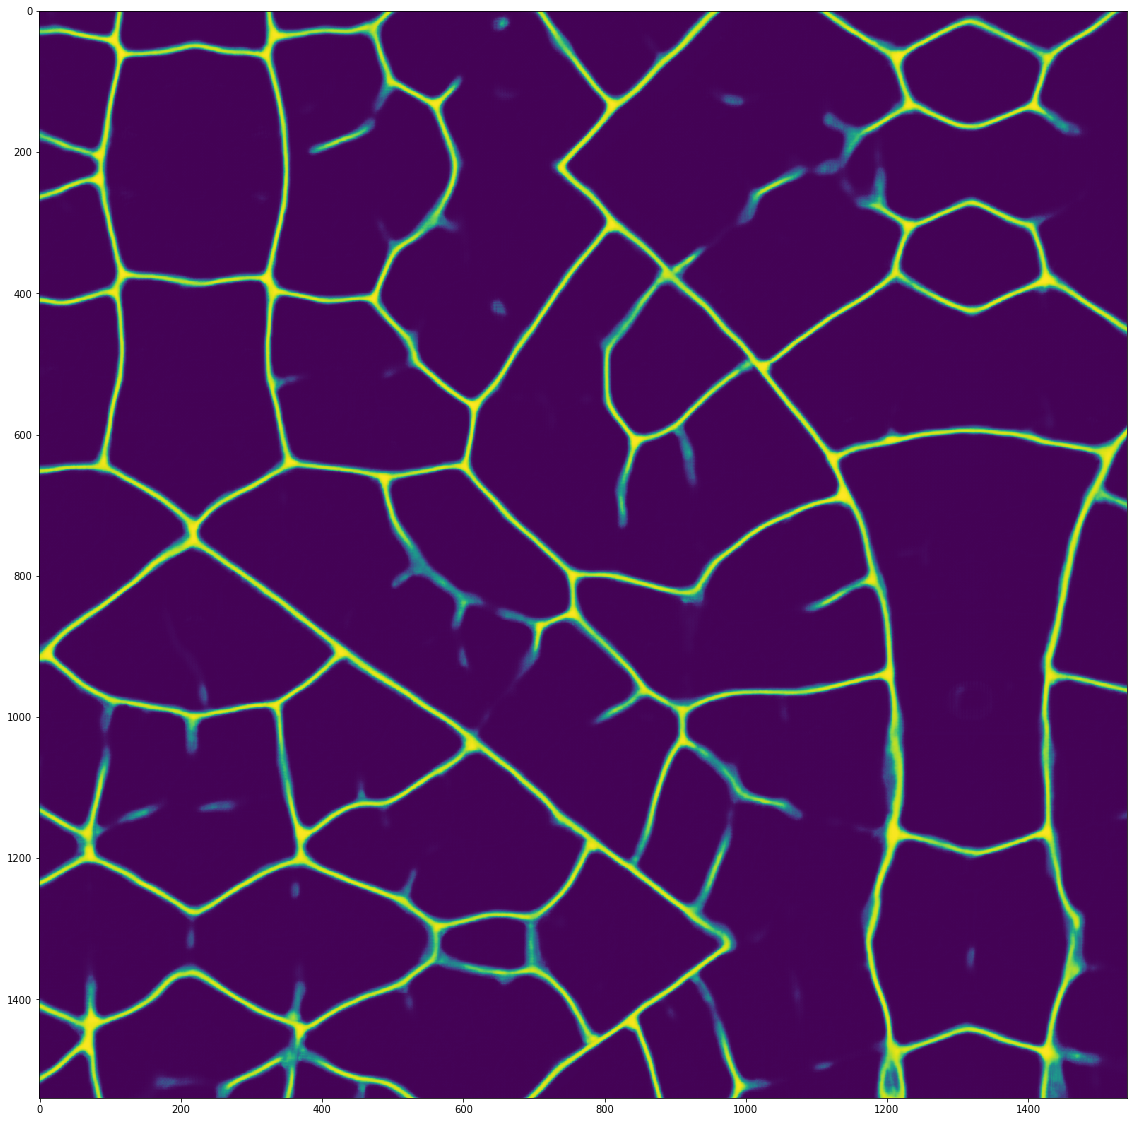

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(y)
plt.show()

View the input image
---------------------

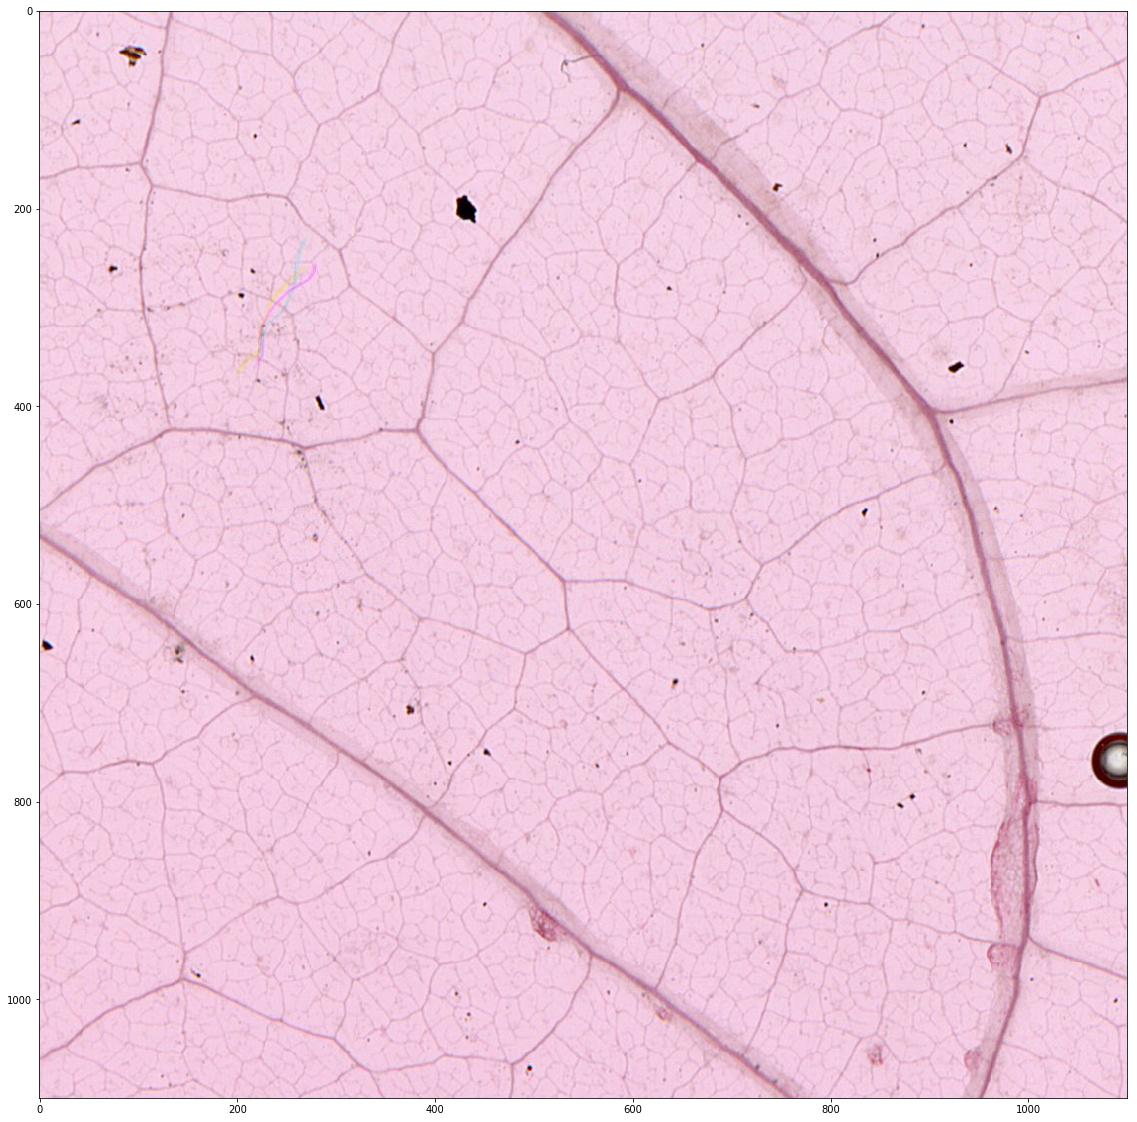

In [10]:
image = io.imread(image_path)
image = image[3500:4600,3500:4600,:]
plt.figure(figsize=(20,20))
plt.imshow(image)

Overlay
-------

A probability threshold is chosen to define forground pixels in the network output. This is then overlayed 
on the original input image. 

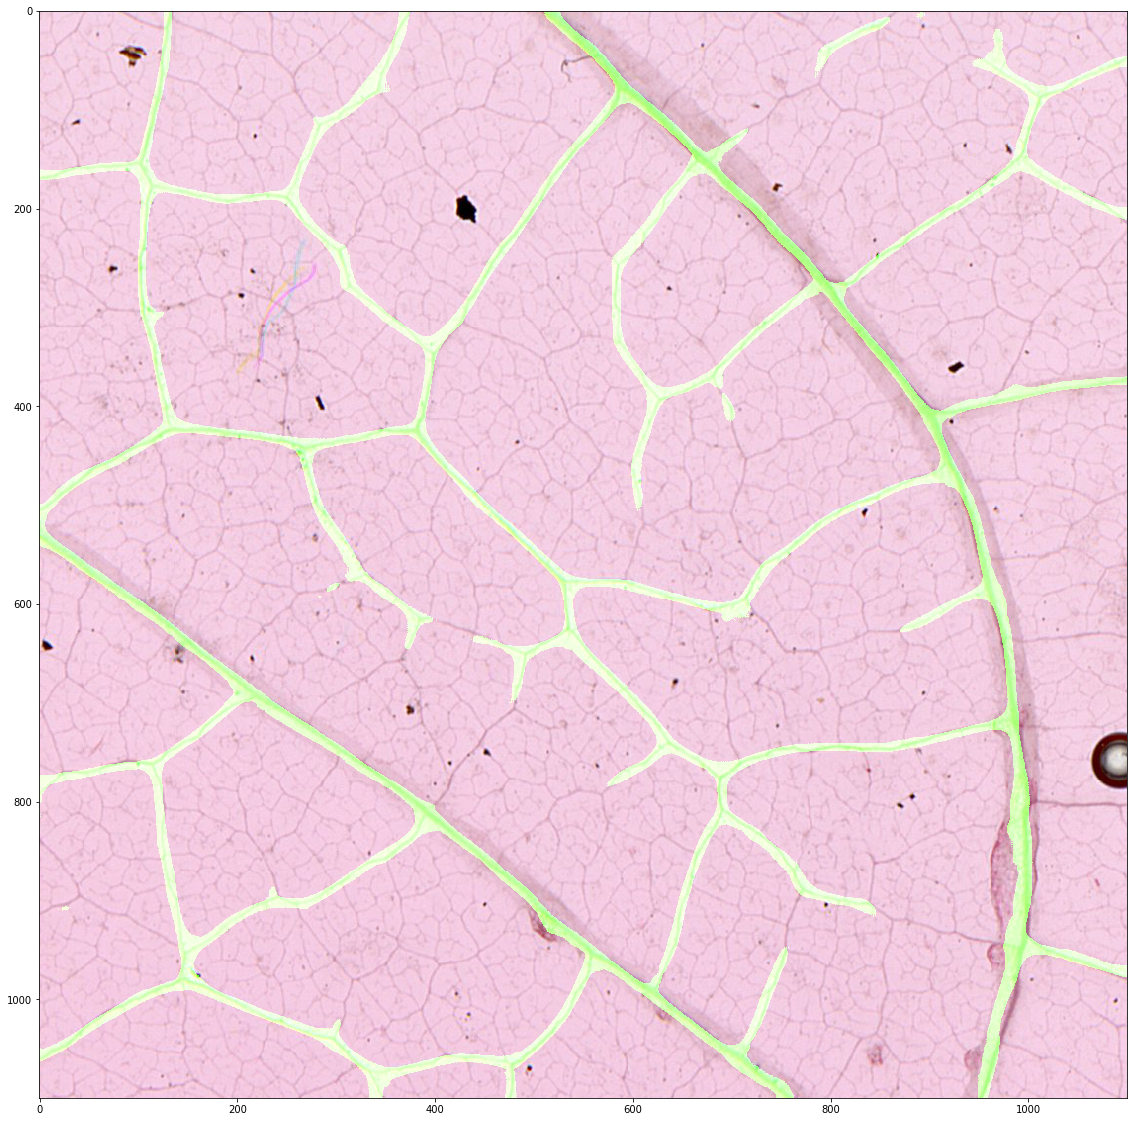

In [11]:
import numpy as np

THRESHOLD = 0.4

def real_indices(y_shape,overlay_shape):
    """
        Returns the array indexing start and stop to get get the real
        image size out of the padded segmentation
    """
    padding = (y_shape - overlay_shape)
    left_pad = math.floor(padding / 2)
    right_pad = math.floor(padding / 2) + padding % 2
    return left_pad, -right_pad

overlay = np.copy(image)
x_start, x_stop = real_indices(y.shape[0],overlay.shape[0])
y_start, y_stop = real_indices(y.shape[1], overlay.shape[1])

seg = y[x_start:x_stop,y_start:y_stop] > THRESHOLD
#seg = y > THRESHOLD

overlay[seg,1] = 255

plt.figure(figsize=(20,20))
plt.imshow(overlay)